In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import nfl_data_py as nfl

In [2]:
def player_id_to_int(player_id):
#     print(player_id)
    return int(player_id[3:])

def save_player_id_map(df, path='csv/player_id_map.csv'):
    df.to_csv(path)
    
def prep_players(df):
    
    #  Extract lists of all unique passers and receivers (as well as their IDs)
    receiver_dict = dict(list(df.groupby(['receiver_player_id','receiver_player_name']).groups.keys()))
    receiver_ids, receiver_names = list(receiver_dict.keys()), list(receiver_dict.values())

    passer_dict = dict(list(df.groupby(['passer_player_id','passer_player_name']).groups.keys()))
    passer_ids, passer_names = list(passer_dict.keys()), list(passer_dict.values())

    #  Lists of receiver and passers can be combined into a list of all players with their IDs
    receivers = {
        'player_id': receiver_ids,
        'player_name': receiver_names
    }

    passers = {
        'player_id': passer_ids,
        'player_name': passer_names
    }

    passer_df = pd.DataFrame.from_dict(passers)
    receiver_df = pd.DataFrame.from_dict(receivers)

    #  This dataframe allows you to get a players name, give their ID, we can save this separately
    player_id_index = pd.concat([passer_df,receiver_df])  # save this to its own CSV file
    save_player_id_map(player_id_index)
    
    return passer_df, receiver_df, player_id_index

def prep_X(df, receiver_df, passer_df):
    
    #  The number of receivers and passers make up the dimensions of X
    rec_ct = receiver_df.shape[0]
    pass_ct = passer_df.shape[0]

    X = np.zeros((rec_ct,pass_ct))

    #  Iterate over the rows of our main dataframe to tally the passing yards for complete pass plays
    #  "For every completed play, get receiver index and passer index and -> X[receiver_idx][passer_idx] += gain"
    for row in df.itertuples(index=False):
        if row.play_type_nfl=='PASS' and not row.interception and not row.qb_spike and not row.incomplete_pass:
            gain = row.receiving_yards

            rec_id = row.receiver_player_id
            receiver_idx = receiver_df.index[receiver_df['player_id'] == rec_id].tolist()[0]

            pass_id = row.passer_player_id
            passer_idx = passer_df.index[passer_df['player_id'] == pass_id].tolist()[0]

    #         print(f'{passer_df.iloc[passer_idx].player_name} to  {receiver_df.iloc[receiver_idx].player_name} for {gain} yards')

            X[receiver_idx][passer_idx] += gain
    return X

def normalize_rows(W_T): # accepts W.T as a parameter
    W_T_norm = np.zeros_like(W_T)
    
    for row in range(W_T.shape[0]):
        row_sum = np.sum(W_T[row])
        W_T_norm[row] = W_T[row] / row_sum
        
    return W_T_norm

def normalize_columns(H_T): # accepts H.T as a parameter
    H_T_norm = np.zeros_like(H_T)
    
    for col in range(H_T.shape[1]):
        col_sum = np.sum(H_T[:,col])
        H_T_norm[:,col] = H_T[:,col] / col_sum
        
    return H_T_norm

def fetch_receiver(index, player_id_index):
    return player_id_index.iloc[index]['player_name']

In [3]:
relevant_columns = [
    'game_id',
    'posteam',
    'pass', # 1
    'play_type_nfl', # PASS
    'incomplete_pass', # 0
    'success', # 1
    'receiving_yards',
    'passer_player_name',
    'receiver_player_name',
    'passer_player_id',
    'receiver_player_id',
    'interception',
    'qb_spike',
    'passer',
    'rusher',
    'receiver',
    'air_yards',
    'desc'
]

nfl_qbs = [
    "C.McCoy",
    "M.Ryan",
    "L.Jackson",
    "Jos.Allen",
    "P.Walker",
    "J.Fields",
    "J.Burrow",
    "B.Mayfield",
    "D.Prescott",
    "T.Bridgewater",
    "J.Goff",
    "Aa.Rodgers",
    "Ty.Taylor",
    "C.Wentz",
    "T.Lawrence",
    "P.Mahomes",
    "D.Carr",
    "J.Herbert",
    "M.Stafford",
    "J.Brissett",
    "K.Cousins",
    "M.Jones",
    "T.Siemian",
    "D.Jones",
    "M.White",
    "J.Hurts",
    "M.Rudolph",
    "J.Garoppolo",
    "R.Wilson",
    "T.Brady",
    "R.Tannehill",
    "T.Heinicke",
    "B"
]



In [4]:
time_period = list(range(2020,2021+1))

nfl_season_pbp = nfl.import_pbp_data(time_period)[relevant_columns]
nfl_season_pbp = nfl_season_pbp.loc[nfl_season_pbp['play_type_nfl'] == 'PASS']
nfl_season_pbp = nfl_season_pbp.loc[pd.notna(nfl_season_pbp['receiver_player_id'])]

2020 done.
2021 done.
Downcasting floats.


In [5]:
passer_df, receiver_df, player_id_index = prep_players(nfl_season_pbp)
X = prep_X(nfl_season_pbp, receiver_df, passer_df)

# NMF must be non-negative! We will treat net-negative yardage as zero-gain
X[X<0] = 0

X.shape

(628, 138)

In [6]:
k_ranks = np.arange(3,15)  # The number of "receiver groups" to learn
tolerance = 0.01 # Stopping condition for training. Smaller value = more training

alpha = 0
alpha_W = alpha # regularization parameter for W
alpha_H = alpha # regularization parameter for H
avg_qb_scores = []


for k in k_ranks:
    
    print(f'K = {k}')

    model = NMF(n_components=k, init='random', tol=tolerance, 
                random_state=0, 
                alpha_W=alpha_W, 
                alpha_H=alpha_H)

    W = model.fit_transform(X)
    H = model.components_

    # --------------------------------------------------------------------------------

    # creating the dataframe
    df_X = pd.DataFrame(data = X, 
                      index = list(receiver_df.player_name), 
                      columns = list(passer_df.player_name))
    # df_X

    # normalizing our learned matrices for analysis
#     sum_of_rows = H.sum(axis=0)
#     H_norm = H / sum_of_rows[np.newaxis]
    H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))

    df_H = pd.DataFrame(data = H_norm, 
                      index = [f'rec_group_{n}' for n in range(H_norm.shape[0])], 
                      columns = list(passer_df.player_name))
    # df_H


#     sum_of_rows = W.sum(axis=1)
#     W_norm = W / sum_of_rows[:, np.newaxis]
    W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))


    df_W = pd.DataFrame(data = W_norm, 
                      index = list(receiver_df.player_name), 
                      columns = [f'rec_group_{n}' for n in range(W_norm.shape[1])])
    # df_W

    # --------------------------------------------------------------------------------

    group_qb_scores = []
    
    for group in range(k):
        
        
        print(f'GROUP {group} out of {k} k-rank group(s)')

        qb_rankings = df_H.loc[f'rec_group_{group}'].where(df_H.loc[f'rec_group_{group}'] > .5).dropna()

        avg_qb_score = 0 

        for qb in qb_rankings.index:
            if (qb in nfl_qbs):
                avg_qb_score += qb_rankings.loc[qb]
    #             print(f'{qb}: {qb_rankings.loc[qb]}')

        avg_qb_score /= len(nfl_qbs)
        group_qb_scores.append(avg_qb_score)

        print(f'average quarterback score: {avg_qb_score}')
        
        print('-------------------------------------\n')
        # All quarterbacks are ranked (qb_rankings), this line takes only those starting in the 2021 season (nfl_qbs)
        print(f'Quarterbacks{list(set(qb_rankings.index) & set(nfl_qbs))}')
        print('\n')
        print(f'Receivers: {list(df_W.nlargest(10,f"rec_group_{group}").iloc[:10].T.columns)}')
    #     display(df_W.nlargest(25,f'rec_group_{group}').iloc[:25].T)
        print('\n\n')
        
    avg_qb_scores.append(np.mean(group_qb_scores))

    print('\n--------------------------------------------------------------------------------\n')

K = 3
GROUP 0 out of 3 k-rank group(s)
average quarterback score: 0.11721149483979512
-------------------------------------

Quarterbacks['D.Prescott', 'T.Brady', 'K.Cousins', 'P.Mahomes']


Receivers: ['L.McCoy', 'R.Gronkowski', 'A.Brown', 'A.Sherman', 'J.Gordon', 'T.Kelce', 'E.Fisher', 'C.Brate', 'M.Evans', 'B.Bell']



GROUP 1 out of 3 k-rank group(s)
average quarterback score: 0.05598902429991992
-------------------------------------

Quarterbacks['Jos.Allen', 'T.Siemian']


Receivers: ['C.Beasley', 'J.Brown', 'S.Diggs', 'J.Kumerow', 'T.Yeldon', 'M.Breida', 'I.McKenzie', 'D.Singletary', 'T.Sweeney', 'D.Knox']



GROUP 2 out of 3 k-rank group(s)
average quarterback score: 0.729532775340694
-------------------------------------

Quarterbacks['M.Jones', 'C.McCoy', 'M.Stafford', 'T.Bridgewater', 'T.Heinicke', 'J.Goff', 'M.White', 'L.Jackson', 'R.Wilson', 'D.Carr', 'J.Fields', 'Aa.Rodgers', 'J.Burrow', 'J.Brissett', 'R.Tannehill', 'Ty.Taylor', 'J.Hurts', 'M.Ryan', 'T.Lawrence', 'B.Mayfi

<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-6-2565a4cbded2>:43: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-6-2565a4cbded2>:43: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-6-2565a4cbded2>:43: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide

GROUP 0 out of 9 k-rank group(s)
average quarterback score: 0.030303030303030304
-------------------------------------

Quarterbacks['T.Brady']


Receivers: ['L.McCoy', 'R.Gronkowski', 'A.Brown', 'C.Brate', 'M.Evans', 'J.Mickens', 'C.Grayson', 'L.Fournette', 'O.Howard', 'C.Godwin']



GROUP 1 out of 9 k-rank group(s)
average quarterback score: 0.045568287983754355
-------------------------------------

Quarterbacks['D.Prescott', 'P.Mahomes']


Receivers: ['A.Sherman', 'J.Gordon', 'T.Kelce', 'E.Fisher', 'T.Hill', 'N.Keizer', 'Darr.Williams', 'M.Hardman', 'J.Fortson', 'C.Edwards-Helaire']



GROUP 2 out of 9 k-rank group(s)
average quarterback score: 0.06035262284981451
-------------------------------------

Quarterbacks['R.Wilson', 'M.Rudolph']


Receivers: ['G.Olsen', 'N.Bellore', 'P.Dorsett', 'T.Lockett', 'A.Collins', 'D.Moore', 'C.Carson', 'W.Dissly', 'P.Hart', 'T.Homer']



GROUP 3 out of 9 k-rank group(s)
average quarterback score: 0.1914703594746206
-------------------------------

<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-6-2565a4cbded2>:43: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-6-2565a4cbded2>:43: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-6-2565a4cbded2>:43: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide

GROUP 0 out of 13 k-rank group(s)
average quarterback score: 0.030303030303030304
-------------------------------------

Quarterbacks['T.Brady']


Receivers: ['L.McCoy', 'R.Gronkowski', 'A.Brown', 'C.Brate', 'M.Evans', 'J.Mickens', 'C.Grayson', 'L.Fournette', 'O.Howard', 'C.Godwin']



GROUP 1 out of 13 k-rank group(s)
average quarterback score: 0.030303030302990735
-------------------------------------

Quarterbacks['P.Mahomes']


Receivers: ['A.Sherman', 'J.Gordon', 'T.Kelce', 'E.Fisher', 'D.Robinson', 'T.Hill', 'G.Dieter', 'M.Kemp', 'N.Keizer', 'B.Pringle']



GROUP 2 out of 13 k-rank group(s)
average quarterback score: 0.030272585970108335
-------------------------------------

Quarterbacks['M.Rudolph']


Receivers: ['V.McDonald', 'E.Ebron', 'D.Watt', 'J.Smith-Schuster', 'K.Rader', 'J.Samuels', 'R.McCloud', 'J.Washington', 'Di.Johnson', 'B.Snell']



GROUP 3 out of 13 k-rank group(s)
average quarterback score: 0.08831088670861532
-------------------------------------

Quarterbacks[

<ipython-input-6-2565a4cbded2>:33: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-6-2565a4cbded2>:43: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))


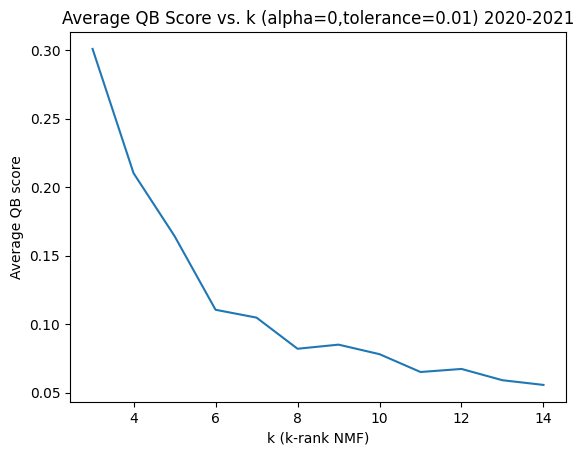

In [7]:
fig = plt.figure()
ax = plt.axes()
ax.plot(k_ranks, avg_qb_scores)
plt.xlabel('k (k-rank NMF)')
plt.ylabel('Average QB score')
plt.title(f'Average QB Score vs. k (alpha=0,tolerance=0.01) {time_period[0]}-{time_period[-1]}')
plt.show()

In [8]:
k_ranks = np.arange(3,15)  # The number of "receiver groups" to learn
tolerance = 0.01 # Stopping condition for training. Smaller value = more training

alpha_vals = np.arange(0, 1, 0.1)
avg_qb_scores = []


for alpha in alpha_vals:
    k=3
    print(f'K = {k}')

    model = NMF(n_components=3, init='random', tol=tolerance, 
                random_state=0, 
                alpha_W=alpha, 
                alpha_H=alpha)

    W = model.fit_transform(X)
    H = model.components_

    # --------------------------------------------------------------------------------

    # creating the dataframe
    df_X = pd.DataFrame(data = X, 
                      index = list(receiver_df.player_name), 
                      columns = list(passer_df.player_name))
    # df_X

    # normalizing our learned matrices for analysis

    H_row_sum = np.sum(H, axis=0).reshape(1,-1)
    H_norm = np.divide(H, H_row_sum, out=np.zeros_like(H), where=H_row_sum!=0)

    df_H = pd.DataFrame(data = H_norm, 
                      index = [f'rec_group_{n}' for n in range(H_norm.shape[0])], 
                      columns = list(passer_df.player_name))
    # df_H


    W_col_sum = np.sum(W, axis=1).reshape(-1,1)
    W_norm = np.divide(W, W_col_sum, out=np.zeros_like(W), where=W_col_sum!=0)


    df_W = pd.DataFrame(data = W_norm, 
                      index = list(receiver_df.player_name), 
                      columns = [f'rec_group_{n}' for n in range(W_norm.shape[1])])
    # df_W

    # --------------------------------------------------------------------------------

    group_qb_scores = []
    
    for group in range(k):
        
        
        print(f'GROUP {group} out of {k} k-rank group(s)')

        qb_rankings = df_H.loc[f'rec_group_{group}'].where(df_H.loc[f'rec_group_{group}'] > .5).dropna()

        avg_qb_score = 0 

        for qb in qb_rankings.index:
            if (qb in nfl_qbs):
                avg_qb_score += qb_rankings.loc[qb]
    #             print(f'{qb}: {qb_rankings.loc[qb]}')

        avg_qb_score /= len(nfl_qbs)
        group_qb_scores.append(avg_qb_score)

        print(f'average quarterback score: {avg_qb_score}')
        
        print('-------------------------------------\n')
        # All quarterbacks are ranked (qb_rankings), this line takes only those starting in the 2021 season (nfl_qbs)
        print(f'Quarterbacks{list(set(qb_rankings.index) & set(nfl_qbs))}')
        print('\n')
        print(f'Receivers: {list(df_W.nlargest(10,f"rec_group_{group}").iloc[:10].T.columns)}')
    #     display(df_W.nlargest(25,f'rec_group_{group}').iloc[:25].T)
        print('\n\n')
        
    avg_qb_scores.append(np.mean(group_qb_scores))

    print('\n--------------------------------------------------------------------------------\n')

K = 3
GROUP 0 out of 3 k-rank group(s)
average quarterback score: 0.11721149483979512
-------------------------------------

Quarterbacks['D.Prescott', 'T.Brady', 'K.Cousins', 'P.Mahomes']


Receivers: ['L.McCoy', 'R.Gronkowski', 'A.Brown', 'A.Sherman', 'J.Gordon', 'T.Kelce', 'E.Fisher', 'C.Brate', 'M.Evans', 'B.Bell']



GROUP 1 out of 3 k-rank group(s)
average quarterback score: 0.05598902429991992
-------------------------------------

Quarterbacks['Jos.Allen', 'T.Siemian']


Receivers: ['C.Beasley', 'J.Brown', 'S.Diggs', 'J.Kumerow', 'T.Yeldon', 'M.Breida', 'I.McKenzie', 'D.Singletary', 'T.Sweeney', 'D.Knox']



GROUP 2 out of 3 k-rank group(s)
average quarterback score: 0.729532775340694
-------------------------------------

Quarterbacks['M.Jones', 'C.McCoy', 'M.Stafford', 'T.Bridgewater', 'T.Heinicke', 'J.Goff', 'M.White', 'L.Jackson', 'R.Wilson', 'D.Carr', 'J.Fields', 'Aa.Rodgers', 'J.Burrow', 'J.Brissett', 'R.Tannehill', 'Ty.Taylor', 'J.Hurts', 'M.Ryan', 'T.Lawrence', 'B.Mayfi

average quarterback score: 0.060277005319879055
-------------------------------------

Quarterbacks['T.Brady', 'J.Burrow']


Receivers: ['L.McCoy', 'R.Gronkowski', 'A.Brown', 'C.Brate', 'M.Evans', 'J.Mickens', 'C.Grayson', 'L.Fournette', 'O.Howard', 'C.Godwin']



GROUP 1 out of 3 k-rank group(s)
average quarterback score: 0.11073902705464461
-------------------------------------

Quarterbacks['L.Jackson', 'J.Garoppolo', 'D.Prescott', 'P.Mahomes']


Receivers: ['A.Sherman', 'J.Gordon', 'T.Kelce', 'E.Fisher', 'B.Bell', 'D.Robinson', 'T.Hill', 'G.Dieter', 'M.Kemp', 'N.Keizer']



GROUP 2 out of 3 k-rank group(s)
average quarterback score: 0.7205619749503192
-------------------------------------

Quarterbacks['M.Jones', 'C.McCoy', 'M.Stafford', 'T.Bridgewater', 'T.Heinicke', 'J.Goff', 'M.White', 'R.Wilson', 'T.Siemian', 'D.Carr', 'J.Fields', 'Aa.Rodgers', 'J.Brissett', 'R.Tannehill', 'K.Cousins', 'Ty.Taylor', 'J.Hurts', 'M.Ryan', 'T.Lawrence', 'B.Mayfield', 'C.Wentz', 'Jos.Allen', 'J.Herb

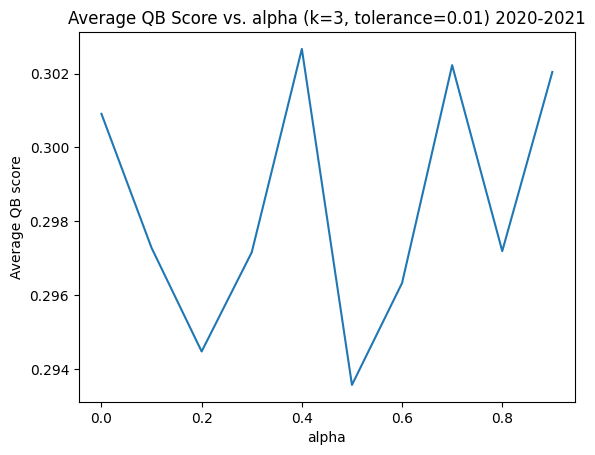

In [9]:
fig = plt.figure()
ax = plt.axes()
ax.plot(alpha_vals, avg_qb_scores)
plt.xlabel('alpha')
plt.ylabel('Average QB score')
plt.title(f'Average QB Score vs. alpha (k=3, tolerance=0.01) {time_period[0]}-{time_period[-1]}')
plt.show()

In [10]:
tolerances = np.arange(0.001, 0.01, 0.001) # Stopping condition for training. Smaller value = more training

alpha = 0.5
avg_qb_scores = []


for tol in tolerances:
    k=3
    print(f'K = {k}')

    model = NMF(n_components=3, init='random', tol=tol, 
                random_state=0, 
                alpha_W=alpha, 
                alpha_H=alpha)

    W = model.fit_transform(X)
    H = model.components_

    # --------------------------------------------------------------------------------

    # creating the dataframe
    df_X = pd.DataFrame(data = X, 
                      index = list(receiver_df.player_name), 
                      columns = list(passer_df.player_name))
    # df_X

    # normalizing our learned matrices for analysis
#     sum_of_rows = H.sum(axis=0)
#     H_norm = H / sum_of_rows[np.newaxis]
    H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))

    df_H = pd.DataFrame(data = H_norm, 
                      index = [f'rec_group_{n}' for n in range(H_norm.shape[0])], 
                      columns = list(passer_df.player_name))
    # df_H


#     sum_of_rows = W.sum(axis=1)
#     W_norm = W / sum_of_rows[:, np.newaxis]
    W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))


    df_W = pd.DataFrame(data = W_norm, 
                      index = list(receiver_df.player_name), 
                      columns = [f'rec_group_{n}' for n in range(W_norm.shape[1])])
    # df_W

    # --------------------------------------------------------------------------------

    group_qb_scores = []
    
    for group in range(k):
        
        
        print(f'GROUP {group} out of {k} k-rank group(s)')

        qb_rankings = df_H.loc[f'rec_group_{group}'].where(df_H.loc[f'rec_group_{group}'] > .5).dropna()

        avg_qb_score = 0 

        for qb in qb_rankings.index:
            if (qb in nfl_qbs):
                avg_qb_score += qb_rankings.loc[qb]
    #             print(f'{qb}: {qb_rankings.loc[qb]}')

        avg_qb_score /= len(nfl_qbs)
        group_qb_scores.append(avg_qb_score)

        print(f'average quarterback score: {avg_qb_score}')
        
        print('-------------------------------------\n')
        # All quarterbacks are ranked (qb_rankings), this line takes only those starting in the 2021 season (nfl_qbs)
        print(f'Quarterbacks{list(set(qb_rankings.index) & set(nfl_qbs))}')
        print('\n')
        print(f'Receivers: {list(df_W.nlargest(10,f"rec_group_{group}").iloc[:10].T.columns)}')
    #     display(df_W.nlargest(25,f'rec_group_{group}').iloc[:25].T)
        print('\n\n')
        
    avg_qb_scores.append(np.mean(group_qb_scores))

    print('\n--------------------------------------------------------------------------------\n')

K = 3
GROUP 0 out of 3 k-rank group(s)
average quarterback score: 0.16312796026515464
-------------------------------------

Quarterbacks['P.Walker', 'P.Mahomes', 'J.Garoppolo', 'L.Jackson', 'T.Bridgewater', 'D.Prescott']


Receivers: ['A.Sherman', 'J.Gordon', 'T.Kelce', 'E.Fisher', 'D.Robinson', 'T.Hill', 'G.Dieter', 'M.Kemp', 'N.Keizer', 'B.Pringle']



GROUP 1 out of 3 k-rank group(s)
average quarterback score: 0.13911509042385586
-------------------------------------

Quarterbacks['M.White', 'Jos.Allen', 'J.Herbert', 'T.Siemian', 'M.Ryan']


Receivers: ['C.Beasley', 'J.Brown', 'S.Diggs', 'J.Kumerow', 'T.Yeldon', 'I.McKenzie', 'D.Singletary', 'T.Sweeney', 'D.Knox', 'G.Davis']



GROUP 2 out of 3 k-rank group(s)
average quarterback score: 0.5851911687558619
-------------------------------------

Quarterbacks['C.McCoy', 'M.Stafford', 'T.Heinicke', 'J.Goff', 'R.Wilson', 'D.Carr', 'J.Fields', 'Aa.Rodgers', 'J.Burrow', 'J.Brissett', 'R.Tannehill', 'K.Cousins', 'Ty.Taylor', 'J.Hurts', 'T.

<ipython-input-10-d4b2316587bf>:30: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-10-d4b2316587bf>:40: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-10-d4b2316587bf>:30: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-10-d4b2316587bf>:40: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-10-d4b2316587bf>:30: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-10-d4b2316587bf>:40: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))
<ipython-input-10-d4b2316587bf>:30: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np

GROUP 0 out of 3 k-rank group(s)
average quarterback score: 0.1274455704515414
-------------------------------------

Quarterbacks['P.Walker', 'P.Mahomes', 'J.Garoppolo', 'L.Jackson', 'D.Prescott']


Receivers: ['A.Sherman', 'J.Gordon', 'T.Kelce', 'E.Fisher', 'D.Robinson', 'T.Hill', 'G.Dieter', 'M.Kemp', 'N.Keizer', 'B.Pringle']



GROUP 1 out of 3 k-rank group(s)
average quarterback score: 0.11152130453464618
-------------------------------------

Quarterbacks['M.White', 'Jos.Allen', 'J.Herbert', 'T.Siemian']


Receivers: ['C.Beasley', 'J.Brown', 'S.Diggs', 'J.Kumerow', 'T.Yeldon', 'I.McKenzie', 'D.Singletary', 'T.Sweeney', 'D.Knox', 'G.Davis']



GROUP 2 out of 3 k-rank group(s)
average quarterback score: 0.6396160951018259
-------------------------------------

Quarterbacks['M.Jones', 'C.McCoy', 'M.Stafford', 'T.Heinicke', 'J.Goff', 'R.Wilson', 'D.Carr', 'J.Fields', 'Aa.Rodgers', 'J.Burrow', 'J.Brissett', 'R.Tannehill', 'K.Cousins', 'Ty.Taylor', 'J.Hurts', 'M.Ryan', 'T.Lawrence', 'B

<ipython-input-10-d4b2316587bf>:30: RuntimeWarning: invalid value encountered in true_divide
  H_norm = np.divide(H,np.sum(H, axis=0).reshape(1,-1))
<ipython-input-10-d4b2316587bf>:40: RuntimeWarning: invalid value encountered in true_divide
  W_norm = np.divide(W,np.sum(W, axis=1).reshape(-1,1))


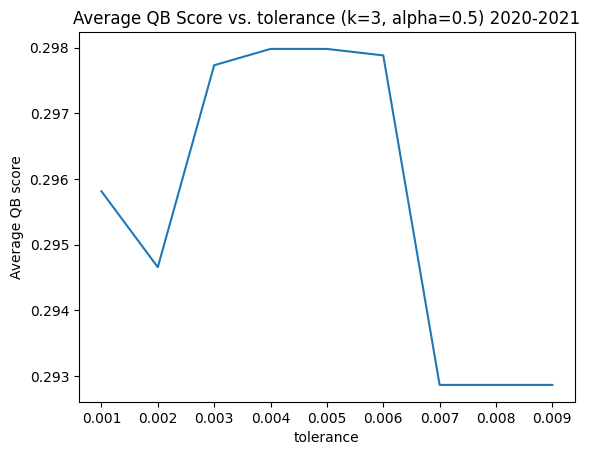

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.plot(tolerances, avg_qb_scores)
plt.xlabel('tolerance')
plt.ylabel('Average QB score')
plt.title(f'Average QB Score vs. tolerance (k=3, alpha=0.5) {time_period[0]}-{time_period[-1]}')
plt.show()

In [12]:
# for group_id in range(groupings):
#     print(f'GROUP {group_id} RECEIVERS')
#     # display(df_W.nlargest(25,f'rec_group_{group_id}'))
#     print(df_W.nlargest(10,f'rec_group_{group_id}').iloc[:10].T.columns)

#     print('\n\n')

#     print(f'QUARTERBACKS THAT PERFORM BEST WITH GROUP {group_id}')
#     # display(df_H.T.nlargest(25,f'rec_group_{group_id}')
#     print(df_H.T.nlargest(5,f'rec_group_{group_id}').iloc[:,:10].T.columns)

#     print('\n')

In [13]:
pd.set_option("display.max_columns", None)
